In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import aparent.visualization as vis

from aparent.predictor import *

import urllib
import urllib.request
import pickle
from time import sleep

from scipy.stats import ttest_ind
from scipy.stats import pearsonr, spearmanr

from sklearn.linear_model import LinearRegression

from scipy.optimize import minimize
from sklearn.metrics import average_precision_score


Using TensorFlow backend.


In [2]:

df = pd.read_csv('predictions/apa_leslie_derti_apadb_pair_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_predictions_pred_df.csv', sep='\t')

#Pre-filters

site_types = ['UTR3', 'Extension']
max_cut_region = 60
min_distance = 100
max_distance = 4000

cell_type = 'pooled'

#Apply global filters
df = df.loc[df.site_type_prox.isin(site_types)]
df = df.loc[df.site_type_dist.isin(site_types)]

df = df.query("(cut_end_prox - cut_start_prox <= " + str(max_cut_region) + ") and (cut_end_dist - cut_start_dist <= " + str(max_cut_region) + ")")
df = df.query("(distance >= " + str(min_distance) + ") and (distance <= " + str(max_distance) + ")")
df = df.query("apadb_pair_count_" + cell_type + " >= 500")

df = df.loc[~df['wide_seq_ext_prox'].str.slice(175 - 70, 175 - 70 + 205).str.contains("AAAAAAA|AAAGAAAA|AAACAAAA|AAAAGAAA|AAAACAAA")]
df = df.loc[~df['wide_seq_ext_dist'].str.slice(175 - 70, 175 - 70 + 205).str.contains("AAAAAAA|AAAGAAAA|AAACAAAA|AAAAGAAA|AAAACAAA")]

pseudo_count = 0.5

l = np.log(np.array(df['distance'].values))

c = np.array(df['apadb_pair_count_' + cell_type].values)
c_prox = np.array(df['apadb_count_' + cell_type + '_prox'].values)
y = np.array(df['apadb_count_' + cell_type + '_prox'].values + pseudo_count) / np.array(df['apadb_pair_count_' + cell_type].values + 2. * pseudo_count)

#Load model predictions

model_names = [
    'aparent-resnet',
    'aparent',
    'deerect-apa',
    'deeppasta',
    'deeppasta_sp',
    'polyapred',
]

model_suffixes = [
    '_apadb_region',
    '_apadb_region',
    '',
    '',
    '',
    '',
]

model_dfs = [
    pd.read_csv('predictions/apa_leslie_derti_apadb_pair_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_predictions_pred_df.csv', sep='\t'),
    pd.read_csv('predictions/apa_leslie_derti_apadb_pair_data/aparent_theano_legacy_30_31_34_pasaligned_predictions_cuts_only_pred_df.csv', sep='\t'),
    pd.read_csv('predictions/apa_leslie_derti_apadb_pair_data/apa_leslie_derti_apadb_pair_data_df_pair_deerect_apa.csv', sep='\t'),
    pd.read_csv('predictions/apa_leslie_derti_apadb_pair_data/apa_leslie_derti_apadb_pair_data_df_pair_deeppasta.csv', sep='\t'),
    pd.read_csv('predictions/apa_leslie_derti_apadb_pair_data/apa_leslie_derti_apadb_pair_data_df_pair_deeppasta_site_predictor.csv', sep='\t'),
    pd.read_csv('predictions/apa_leslie_derti_apadb_pair_data/apa_leslie_derti_apadb_pair_data_df_pair_polyapred_shifted.csv', sep='\t'),
]

model_scores = []
for model_ix in range(len(model_dfs)) :
    model_dfs[model_ix] = model_dfs[model_ix].join(df[['gene_id']].set_index('gene_id'), on='gene_id', how='inner').copy().reset_index(drop=True)
    model_scores.append([np.array(model_dfs[model_ix]['score_prox' + model_suffixes[model_ix]].values), np.array(model_dfs[model_ix]['score_dist' + model_suffixes[model_ix]].values)])

print(len(df))


3098


In [3]:
#Filter apa-only version (for logodds regression)

keep_index = np.nonzero((c_prox > 0.) & (c_prox < c))[0]

model_scores_apa_only = []
for model_ix in range(len(model_scores)) :
    model_score_apa_only = [
        model_scores[model_ix][0][keep_index, ...],
        model_scores[model_ix][1][keep_index, ...]
    ]
    model_scores_apa_only.append(model_score_apa_only)

l_apa_only = l[keep_index, ...]
c_apa_only = c[keep_index, ...]
c_prox_apa_only = c_prox[keep_index, ...]
y_apa_only = y[keep_index, ...]

logodds_apa_only = np.log(y_apa_only / (1. - y_apa_only))

print("y_apa_only.shape = " + str(y_apa_only.shape))


y_apa_only.shape = (3098,)


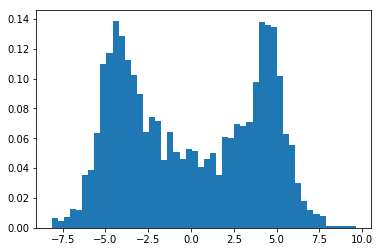

In [4]:

f = plt.figure(figsize=(6, 4))

plt.hist(logodds_apa_only, bins=50, density=True)

plt.show()


Evaluating model = 'aparent-resnet'
Regression task.
Spearman r = 0.876
n = 3098


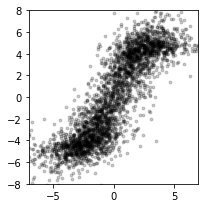

Classification task.
Optimization terminated successfully.
         Current function value: 0.131041
         Iterations: 22
         Function evaluations: 144
         Gradient evaluations: 24
AP = 0.96
n = 3098


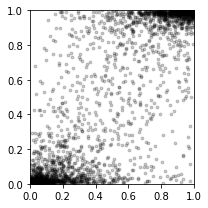

Evaluating model = 'aparent'
Regression task.
Spearman r = 0.795
n = 3098


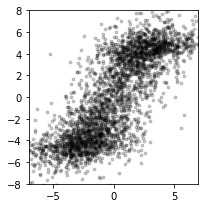

Classification task.
Optimization terminated successfully.
         Current function value: 0.211331
         Iterations: 18
         Function evaluations: 120
         Gradient evaluations: 20
AP = 0.92
n = 3098


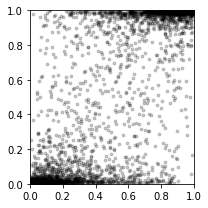

Evaluating model = 'deerect-apa'
Regression task.
Spearman r = 0.556
n = 3098


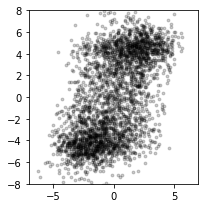

Classification task.
Optimization terminated successfully.
         Current function value: 0.372378
         Iterations: 18
         Function evaluations: 120
         Gradient evaluations: 20
AP = 0.78
n = 3098


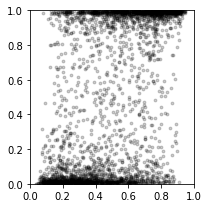

Evaluating model = 'deeppasta'
Regression task.
Spearman r = 0.646
n = 3098


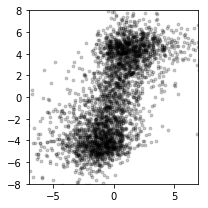

Classification task.
Optimization terminated successfully.
         Current function value: 0.322402
         Iterations: 19
         Function evaluations: 132
         Gradient evaluations: 22
AP = 0.85
n = 3098


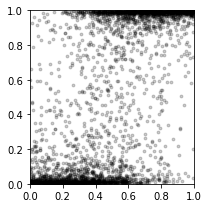

Evaluating model = 'deeppasta_sp'
Regression task.
Spearman r = 0.366
n = 3098


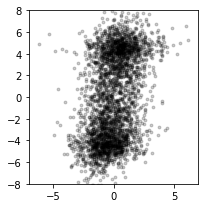

Classification task.
Optimization terminated successfully.
         Current function value: 0.449450
         Iterations: 14
         Function evaluations: 102
         Gradient evaluations: 17
AP = 0.66
n = 3098


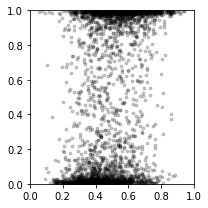

Evaluating model = 'polyapred'
Regression task.
Spearman r = 0.523
n = 3098


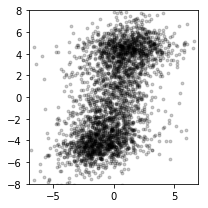

Classification task.
Optimization terminated successfully.
         Current function value: 0.398576
         Iterations: 18
         Function evaluations: 120
         Gradient evaluations: 20
AP = 0.74
n = 3098


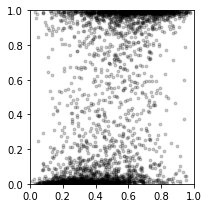

In [5]:
#Fit and evaluate regression / classification models on native measures

def logistic_model_predict(s_prox, s_dist, l, w_prox, w_dist, w_len, w_bias) :
    
    prox_exp = 1. / (1. + np.exp(-1. * (w_prox * s_prox + w_dist * s_dist + w_len * l + w_bias)))
    
    return prox_exp

def logistic_model_kl(w_bundle, s_prox, s_dist, l, y_true) :
    
    w_prox, w_dist, w_len, w_bias = w_bundle[0], w_bundle[1], w_bundle[2], w_bundle[3]
    
    y_pred = logistic_model_predict(s_prox, s_dist, l, w_prox, w_dist, w_len, w_bias)
    
    y_pred_clip = np.clip(y_pred, 1e-7, 1. - 1e-7)
    y_true_clip = np.clip(y_true, 1e-7, 1. - 1e-7)
    
    kl = y_true_clip * np.log(y_true_clip / y_pred_clip) + (1. - y_true_clip) * np.log((1. - y_true_clip) / (1. - y_pred_clip))
    
    return np.mean(kl)

model_spearman_rs = np.zeros(len(model_scores))
model_aps = np.zeros(len(model_scores))

for model_ix in range(len(model_scores)) :
    
    print("Evaluating model = '" + model_names[model_ix] + "'")
    
    print("Regression task.")

    lr = LinearRegression().fit(np.concatenate([
        model_scores_apa_only[model_ix][0][:, None],
        model_scores_apa_only[model_ix][1][:, None],
        l_apa_only[:, None],
    ], axis=-1), logodds_apa_only)

    logodds_pred_apa_only = lr.predict(np.concatenate([
        model_scores_apa_only[model_ix][0][:, None],
        model_scores_apa_only[model_ix][1][:, None],
        l_apa_only[:, None],
    ], axis=-1))

    spearman_r_val, _ = spearmanr(logodds_pred_apa_only, logodds_apa_only)
    model_spearman_rs[model_ix] = spearman_r_val

    print("Spearman r = " + str(round(spearman_r_val, 3)))
    print("n = " + str(logodds_pred_apa_only.shape[0]))

    f = plt.figure(figsize=(3, 3))

    plt.scatter(logodds_pred_apa_only, logodds_apa_only, color='black', s=8, alpha=0.2)

    plt.xlim(-7., 7.)
    plt.ylim(-8., 8.)

    plt.tight_layout()
    
    plt.savefig("apadb_pairwise_scatter_" + model_names[model_ix] + ".png", dpi=300, transparent=True)
    plt.savefig("apadb_pairwise_scatter_" + model_names[model_ix] + ".eps")
    
    plt.show()

    print("Classification task.")

    w0 = np.zeros(4)

    res = minimize(logistic_model_kl, w0, args=(model_scores[model_ix][0], model_scores[model_ix][1], l, y), method='BFGS', options={'disp': True})
    y_pred = logistic_model_predict(model_scores[model_ix][0], model_scores[model_ix][1], l, res.x[0], res.x[1], res.x[2], res.x[3])

    y_labels = np.array([1. if y[i] >= 0.5 else 0. for i in range(y.shape[0])])

    ap = average_precision_score(y_labels, y_pred)
    model_aps[model_ix] = ap

    print("AP = " + str(round(ap, 2)))
    print("n = " + str(y_pred.shape[0]))

    f = plt.figure(figsize=(3, 3))

    plt.scatter(y_pred, y, color='black', s=8, alpha=0.2)

    plt.xlim(0., 1.)
    plt.ylim(0., 1.)

    plt.tight_layout()
    plt.show()


In [13]:
#Save metrics

np.save("native_apa_pairwise_apadb_spearman_rs", model_spearman_rs)
np.save("native_apa_pairwise_apadb_aps", model_aps)


In [6]:
#Load metrics

model_spearman_rs_apadb = np.load("native_apa_pairwise_apadb_spearman_rs.npy")
model_aps_apadb = np.load("native_apa_pairwise_apadb_aps.npy")

model_spearman_rs_leslie = np.load("native_apa_pairwise_leslie_spearman_rs.npy")
model_aps_leslie = np.load("native_apa_pairwise_leslie_aps.npy")

model_spearman_rs_derti = np.load("native_apa_pairwise_derti_spearman_rs.npy")
model_aps_derti = np.load("native_apa_pairwise_derti_aps.npy")


APADB  Spearman r = [0.88, 0.79, 0.56, 0.65, 0.37, 0.52]
Leslie Spearman r = [0.58, 0.43, 0.32, 0.4, 0.19, 0.26]
Derti  Spearman r = [0.76, 0.69, 0.4, 0.64, 0.31, 0.44]


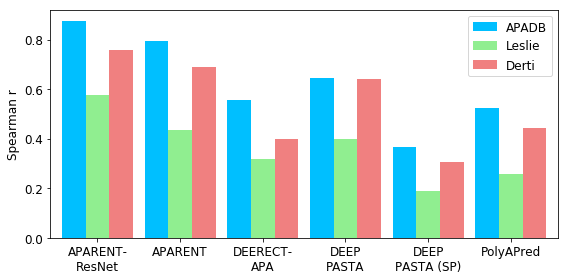

APADB  AP = [0.96, 0.92, 0.78, 0.85, 0.66, 0.74]
Leslie AP = [0.89, 0.79, 0.74, 0.79, 0.61, 0.71]
Derti  AP = [0.91, 0.89, 0.71, 0.86, 0.65, 0.72]


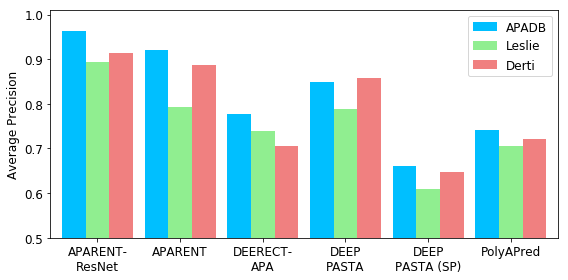

In [7]:

print("APADB  Spearman r = " + str(np.round(model_spearman_rs_apadb, 2).tolist()))
print("Leslie Spearman r = " + str(np.round(model_spearman_rs_leslie, 2).tolist()))
print("Derti  Spearman r = " + str(np.round(model_spearman_rs_derti, 2).tolist()))

f = plt.figure(figsize=(8, 4))

plt.bar(np.arange(model_spearman_rs_apadb.shape[0]) * 3.5, model_spearman_rs_apadb, width=1., edgecolor='black', color='deepskyblue', linewidth=0, label='APADB')
plt.bar(np.arange(model_spearman_rs_leslie.shape[0]) * 3.5 + 1, model_spearman_rs_leslie, width=1., edgecolor='black', color='lightgreen', linewidth=0, label='Leslie')
plt.bar(np.arange(model_spearman_rs_derti.shape[0]) * 3.5 + 2, model_spearman_rs_derti, width=1., edgecolor='black', color='lightcoral', linewidth=0, label='Derti')

plt.xlim(-1.0, 20.5)

plt.xticks([1, 4.5, 8, 11.5, 15, 18.5], ['APARENT-\nResNet', 'APARENT', 'DEERECT-\nAPA', 'DEEP\nPASTA', 'DEEP\nPASTA (SP)', 'PolyAPred'], fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel('Spearman r', fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("native_apa_pairwise_eval_bars_spearman_r.png", transparent=True, dpi=300)
plt.savefig("native_apa_pairwise_eval_bars_spearman_r.eps")

plt.show()


print("APADB  AP = " + str(np.round(model_aps_apadb, 2).tolist()))
print("Leslie AP = " + str(np.round(model_aps_leslie, 2).tolist()))
print("Derti  AP = " + str(np.round(model_aps_derti, 2).tolist()))

f = plt.figure(figsize=(8, 4))

plt.bar(np.arange(model_aps_apadb.shape[0]) * 3.5, model_aps_apadb, width=1., edgecolor='black', color='deepskyblue', linewidth=0, label='APADB')
plt.bar(np.arange(model_aps_leslie.shape[0]) * 3.5 + 1, model_aps_leslie, width=1., edgecolor='black', color='lightgreen', linewidth=0, label='Leslie')
plt.bar(np.arange(model_aps_derti.shape[0]) * 3.5 + 2, model_aps_derti, width=1., edgecolor='black', color='lightcoral', linewidth=0, label='Derti')

plt.xlim(-1.0, 20.5)
plt.ylim(0.5)

plt.xticks([1, 4.5, 8, 11.5, 15, 18.5], ['APARENT-\nResNet', 'APARENT', 'DEERECT-\nAPA', 'DEEP\nPASTA', 'DEEP\nPASTA (SP)', 'PolyAPred'], fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel('Average Precision', fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("native_apa_pairwise_eval_bars_ap.png", transparent=True, dpi=300)
plt.savefig("native_apa_pairwise_eval_bars_ap.eps")

plt.show()
